## Load the libraries and custom function to be use.

In [2]:
# load some library needed and functions

import os
import json
import sounddevice as sd
import soundfile as sf
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import lbg
from lbg import generate_codebook, avg_distortion_c_list, avg_vec_of_vecs, avg_distortion_c0, split_codebook
from sklearn.cluster import KMeans
from scipy.fftpack import dct


def record_audio(seconds, user_name, entry):
    fs = 44100  # Sampling frequency
    duration = seconds  # Duration of recording in seconds
    
    
    print("Recording...")

    
    # Record audio from the microphone
    audio = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype=np.float32)
    sd.wait()

    print("Finished recording.")

    if user_name:
        filename = f"voice_{user_name}_{entry}.wav"
        folder_path = os.path.join(os.getcwd(), 'Users_samples', user_name, filename)
        # Save audio to file
        sf.write(folder_path, audio, fs, subtype='PCM_24')
        print(f"Audio recorded and saved as {folder_path}")
    
    
    return audio, fs


def extract_mfcc_file(audio_file, num_mfcc, frame_length, hop_length):
    # Load audio file
    y, sr = librosa.load(audio_file)

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc, n_fft=frame_length, hop_length=hop_length)

    return mfccs

def extract_mfcc(audio_waveform, sr, num_mfcc, frame_length, hop_length):
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio_waveform, sr=sr, n_mfcc=num_mfcc, n_fft=frame_length, hop_length=hop_length)

    return mfccs

def calculate_distortion(sample_mfcc, codebook):
    # Initialize total distortion
    total_distortion = 0.0
    
    # Assign each sample MFCC to its nearest centroid in the codebook
    nearest_centroids = np.argmin(np.linalg.norm(sample_mfcc[:, None, :] - codebook, axis=2), axis=1)
    
    # Calculate the Euclidean distance between each sample MFCC and its assigned centroid
    for i, centroid_index in enumerate(nearest_centroids):
        centroid = codebook[centroid_index]
        distortion = np.linalg.norm(sample_mfcc[i] - centroid)
        total_distortion += distortion
        
        # for average distortion, divide the total by sample_mfcc.shape[0]
    average_distortion=total_distortion/sample_mfcc.shape[0]
    return average_distortion


def create_user_folder(user_name):
    # Create folder path
    user_folder='Users_samples'
    folder_path = os.path.join(os.getcwd(), user_folder, user_name)

    # Check if folder exists
    if not os.path.exists(folder_path):
        # Create folder if it doesn't exist
        os.makedirs(folder_path)
        print(f"Folder '{user_name}' created successfully.")
    else:
        print(f"Folder '{user_name}' already exists.")
    
    file_count = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
    return file_count, folder_path

def scale_number(unscaled, to_min, to_max, from_min, from_max):
    return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

def scale_list(l, to_min, to_max):
    return [scale_number(i, to_min, to_max, min(l), max(l)) for i in l]



## Enter users to the system and plot the time signal and FFT

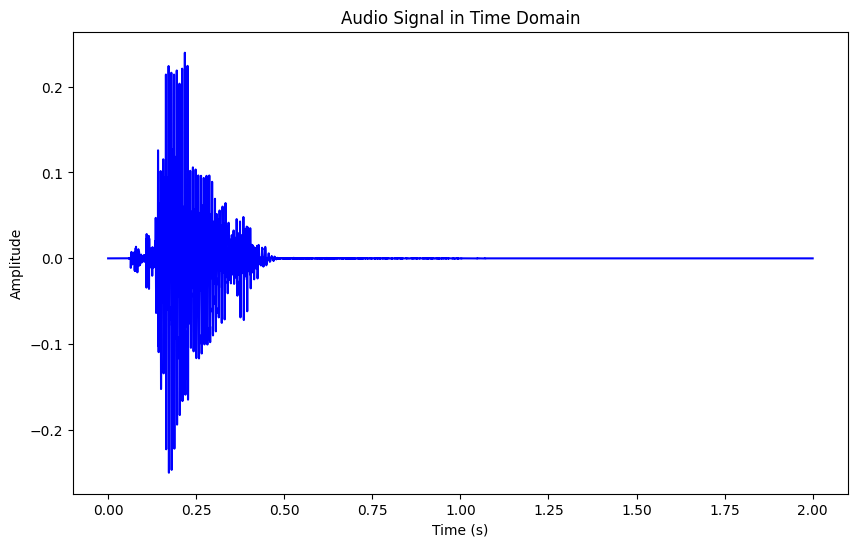

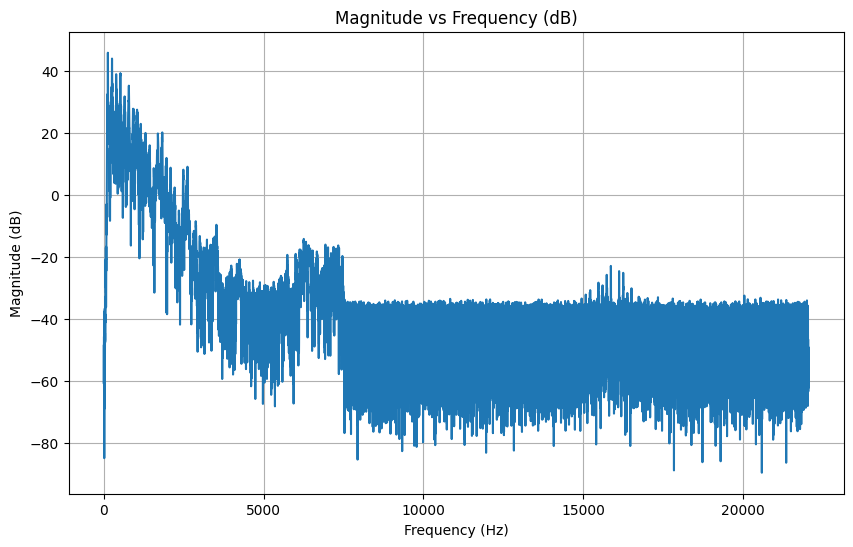

In [7]:
# user_name = input("Enter your name: ")
# entry, folder = create_user_folder(user_name)

# audio_file, fs = record_audio(2, user_name, entry+1)

fs=44100

sample_path= os.path.join(os.getcwd(), 'Cesar_10.wav')
audio_file, sr = librosa.load(sample_path, sr=fs)

audio = audio_file.reshape(-1)

time_axis = np.arange(len(audio)) / fs



# Plot audio signal in time domain
plt.figure(figsize=(10, 6))
#plt.subplot(2, 1, 1)
plt.plot(time_axis, audio, color='b')
plt.title('Audio Signal in Time Domain')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


N=len(audio)
audio_signal_fft = np.fft.fft(audio)
frequencies = np.fft.fftfreq(N, 1/fs)

positive_frequencies = frequencies[:N//2]
magnitudes = np.abs(audio_signal_fft)[:N//2]

# Magnitudes to decibels (dB)
magnitudes_db = 20 * np.log10(magnitudes)

# Magnitude vs frequency 
plt.figure(figsize=(10, 6))
plt.plot(positive_frequencies, magnitudes_db)
plt.title('Magnitude vs Frequency (dB)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()




## Step by step MFCC generation

### Short-time Fast Fourier Transform

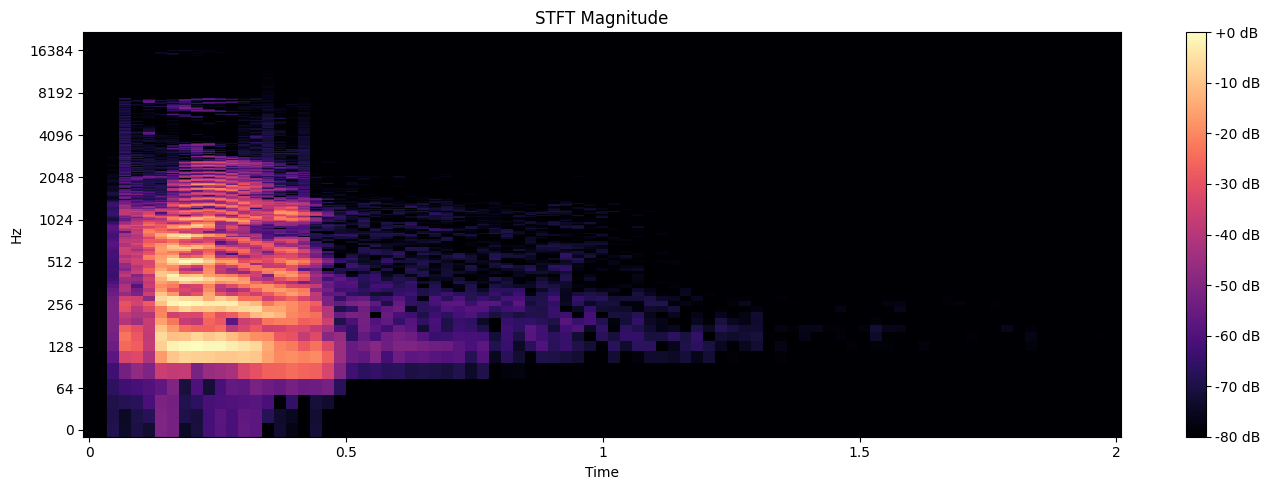

In [8]:
# settings for STFT parameters
n_fft = 2048          # Length of the FFT window
hop_length = 1024      # Number of samples between successive frames
win_length = None     # Window size (if None, defaults to n_fft)
window = 'hamming'       # Window function (e.g., 'hann', 'hamming', 'blackmanharris')

# STFT Amplitud
D = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)

# Amplitude to dB
D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(D_db, sr=fs, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Magnitude')
plt.tight_layout()
plt.show()


### Generate the Mel Frequency Banks

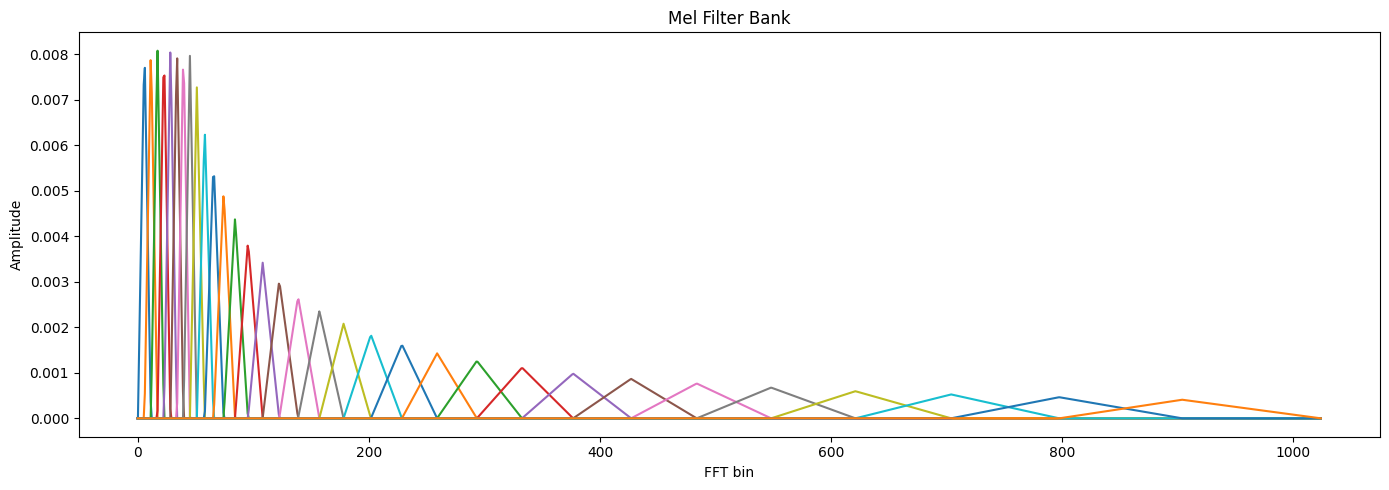

In [9]:
# Mel frequency Banks

n_mels = 32        # Number of Mel bands

# Create a Mel filter bank
mel_filter_bank = librosa.filters.mel(sr=fs, n_fft=n_fft, n_mels=n_mels)

# Plot the Mel filter bank
plt.figure(figsize=(14, 5))
for i in range(n_mels):
    plt.plot(mel_filter_bank[i])
plt.xlabel('FFT bin')
plt.ylabel('Amplitude')
plt.title('Mel Filter Bank')
plt.tight_layout()
plt.show()

## Apply the generated Mel-bank to the STFFT and convert it to log scale

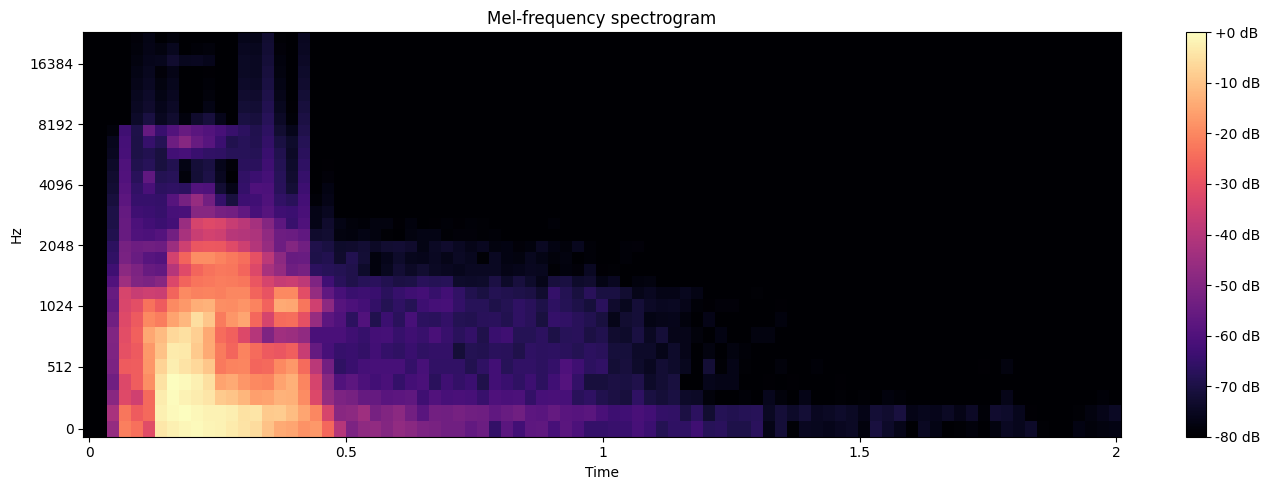

In [10]:
# Lets apply the Mel filter bank to the magnitude of the STFT
S_mel = np.dot(mel_filter_bank, np.abs(D))

# Amplitude to dB
S_mel_db = librosa.amplitude_to_db(S_mel, ref=np.max)

# Plot 
plt.figure(figsize=(14, 5))
librosa.display.specshow(S_mel_db, sr=fs, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

## Final MFCC step, apply a Discrete Cosine Transform to the Mel-spectrogram

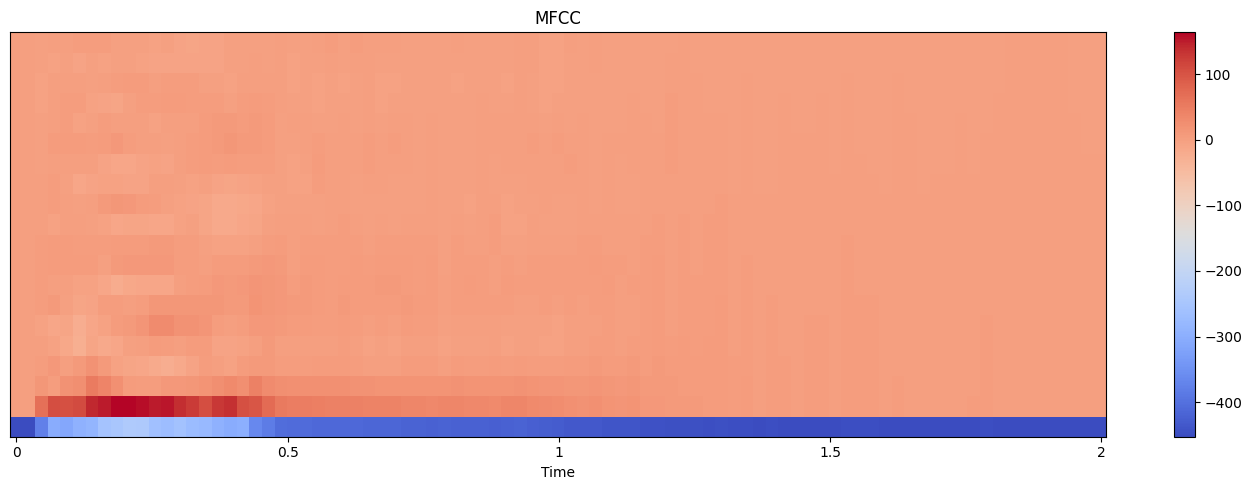

In [11]:
# DCT to the Mel-spectrogram 
n_mfcc = 20           # Number of MFCCs to return
mfccs = dct(S_mel_db, axis=0, type=2, norm='ortho')[:n_mfcc]

# Plot the MFCCs
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfccs, sr=fs, hop_length=hop_length, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

## Lets plot the MFCC features in 2D plane

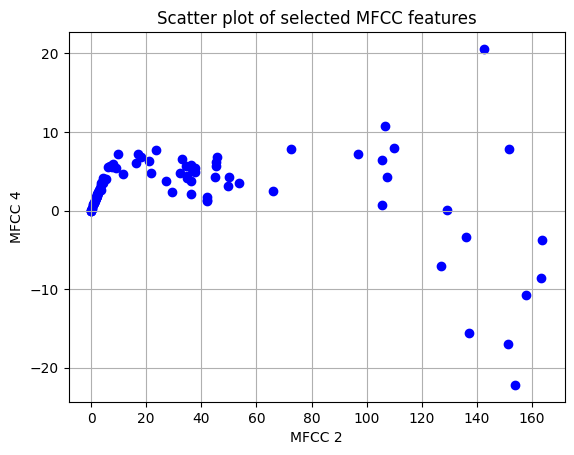

In [12]:
# MFCC indices to plot
mfcc1_idx = 1
mfcc2_idx = 3

# Initialize the plot
fig, ax = plt.subplots()
sc = ax.scatter(mfccs[mfcc1_idx], mfccs[mfcc2_idx], c='b', marker='o')
ax.set_xlabel(f'MFCC {mfcc1_idx + 1}')
ax.set_ylabel(f'MFCC {mfcc2_idx + 1}')
ax.set_title('Scatter plot of selected MFCC features')
ax.grid(True)
plt.show()


## Vector quantization for Codebook generation (information compression)

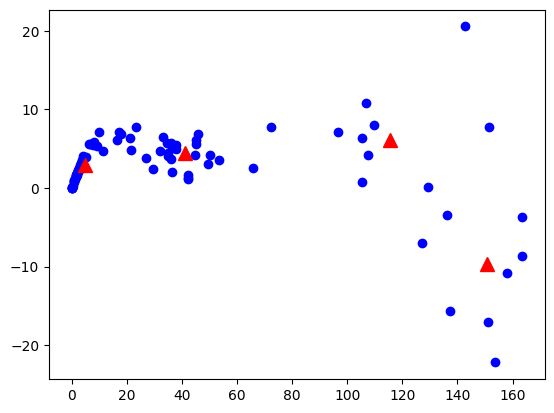

In [13]:
# only once to create
all_dispersions=[]
all_depth=[]
#######

codebook_depth=4
cb, cb_abs_w, cb_rel_w = lbg.generate_codebook(mfccs.T,codebook_depth)

# calculate the average distortion
avg_dist = calculate_distortion(mfccs.T, cb)



# Plot the constellation diagram
#plt.figure(figsize=(14, 5))
plt.scatter(mfccs[mfcc1_idx], mfccs[mfcc2_idx], c='b', marker='o', label='MFCC features')

for i, instance in enumerate(cb):
    plt.plot(instance[mfcc1_idx], instance[mfcc2_idx], marker='^', markersize=10, color='red')


all_dispersions.append(avg_dist)
all_depth.append(codebook_depth)

## Codebook depth optimal estimation

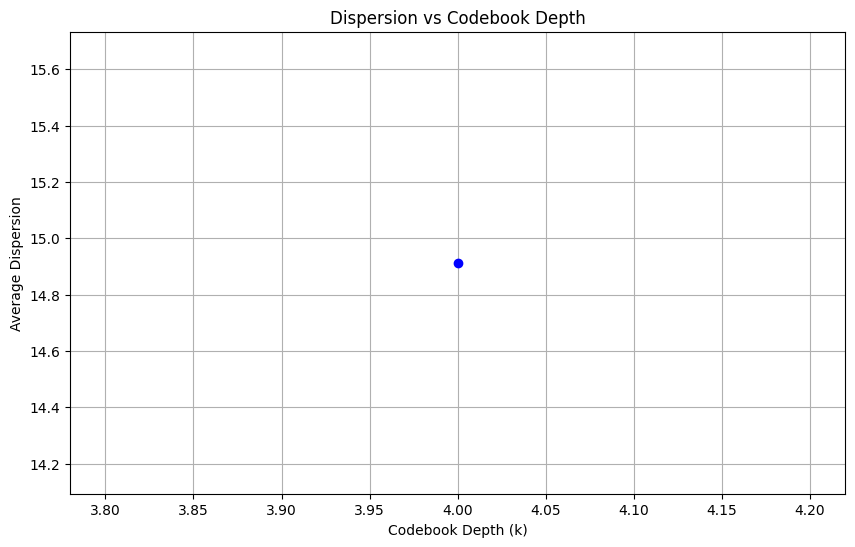

In [14]:
# Plot dispersion vs codebook depth
plt.figure(figsize=(10, 6))
plt.plot(all_depth, all_dispersions, marker='o', linestyle='-', color='b')
plt.xlabel('Codebook Depth (k)')
plt.ylabel('Average Dispersion')
plt.title('Dispersion vs Codebook Depth')
plt.grid(True)
plt.show()